# Plot all models, deconfounding and denoising

In [1]:
import pandas as pd
import numpy as np

phenotype = 'group'
#denoise_list = ["simple", "scrubbing.5", "simple+gsr", "scrubbing.5+gsr"]
denoise_list = ["simple", "simple+gsr"]
model_list = ["logreg", "multilayer_metamatch", "metamatch"]
resample = 0

# load results
in_path = '../results/model_performance/'
in_dfs = {'accuracy': [], 'roc': [], 'confounders': []}
for model in model_list:
    for denoise in denoise_list:
        if resample != 0:
            in_file = f"model-{model}_phenotype-{phenotype}_denoise-{denoise}_N{resample}.csv"
        else:
            in_file = f"model-{model}_phenotype-{phenotype}_denoise-{denoise}.csv"

        for i in ['accuracy', 'roc']:
            _df = pd.read_csv(in_path+i+'_'+in_file)
            _df['resample'] = resample
            in_dfs[i].append(_df)

accuracy_df = pd.concat(in_dfs['accuracy'], axis=0, ignore_index=True)
print(accuracy_df.shape)
#roc_df = pd.concat(in_dfs['roc'], axis=0, ignore_index=True)
#confounders_df = pd.concat(in_dfs['confounders'], axis=0, ignore_index=True)

(32000, 11)


In [2]:
# clean the df

# Include both raw and deconfounded data
models = ['logreg', 'logreg_site_confounds_removed',
          'multilayer_metamatch', 'multilayer_metamatch_site_confounds_removed',
          'metamatch', 'metamatch_site_confounds_removed']

# Filter the results df
df = accuracy_df.loc[
    (accuracy_df['model'].isin(models))
    & (accuracy_df['permuted'] == False)
    & (accuracy_df['resample'] == 0)]
df['acc_fmt'] = df.acc.values * 100

# Reorganise so that deconfounding is a column
df[['model','deconfounded']] = df['model'].str.split('_site_confounds_',expand=True)
df.loc[df.deconfounded != 'removed', 'deconfounded'] = "Raw"
df.loc[df.deconfounded == 'removed', 'deconfounded'] = "Deconf."


# Rename the models for the legend
df['denoise'].replace('scrubbing.5', 'scrub', inplace=True)
df['denoise'].replace('scrubbing.5+gsr', 'scrub+gsr', inplace=True)

# Rename the models for the legend
df['model'].replace('logreg','BLR', inplace=True)
df['model'].replace('multilayer_metamatch','MM (m.layer)', inplace=True)
df['model'].replace('metamatch','MM (orig.)', inplace=True)

df[['denoise', 'gsr']] = df['denoise'].str.split("+", expand=True)
df['gsr'].fillna(value=False, inplace=True)
df['gsr'].replace('gsr', True, inplace=True)

#df['model'].replace('metamatch','Meta-match', inplace=True)
# # Reorganise denoise
# df[['denoise','gsr']] = df['denoise'].str.split('+',expand=True)
# # Rename the models for the legend
# df['gsr'].fillna("False", inplace=True)
# df['gsr'].replace('gsr', "True", inplace=True)

/tmp/ipykernel_3000590/2425318873.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acc_fmt'] = df.acc.values * 100
/tmp/ipykernel_3000590/2425318873.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['model','deconfounded']] = df['model'].str.split('_site_confounds_',expand=True)
/tmp/ipykernel_3000590/2425318873.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

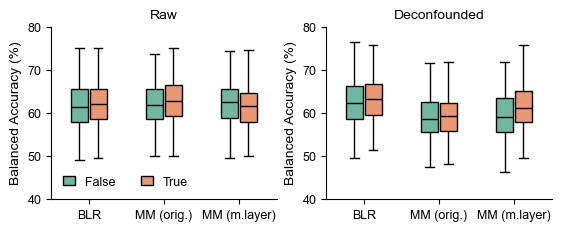

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

fig, axs = plt.subplot_mosaic("""
                              AB
                              """,figsize=(5.5, 2.2),
                              constrained_layout=True)
ax = axs['A']
data = df[df.deconfounded == 'Raw']
sns.boxplot(ax=ax,
            data=data,
            x='model',
            order=["BLR", "MM (orig.)", "MM (m.layer)"],
            y='acc_fmt',
            hue='gsr',
            palette="Set2",
            fliersize=0, 
            linecolor='k', 
            linewidth=1, 
            width=0.5, 
            gap=0.1, 
            legend=True)

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_ylabel("Balanced Accuracy (%)", fontsize=10)
ax.set_xlabel("", fontsize=10)
ax.set_ylim(40, 80)
sns.despine(ax=ax)
ax.legend(frameon=False, loc='lower left', ncol=2,
          fontsize=9, handlelength=1)
ax.set_title('Raw', fontsize=10)

ax = axs['B']
data = df[df.deconfounded == 'Deconf.']
sns.boxplot(ax=ax,
            data=data,
            x='model',
            order=["BLR", "MM (orig.)", "MM (m.layer)"],
            y='acc_fmt',
            hue='gsr',
            palette="Set2",
            fliersize=0, 
            linecolor='k', 
            linewidth=1, 
            width=0.5, 
            gap=0.1, 
            legend=False)

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_ylabel("Balanced Accuracy (%)", fontsize=10)
ax.set_xlabel("", fontsize=10)
ax.set_ylim(40, 80)
ax.set_title('Deconfounded', fontsize=10)
sns.despine(ax=ax)
plt.savefig('../results/figures/all_model_comparison.jpeg', dpi=600, bbox_inches='tight')
plt.show()

# Compare original MM and ML MM

In [4]:
import numpy as np
from scipy.stats import t

def CBIG_corrected_resampled_ttest(accuracy_vec, portion, threshold):
    """
    This function tests whether an accuracy vector (obtained from cross-validation) 
    is statistically different from a threshold. The accuracy vector can also
    represent the difference between two classifiers. The key point of this
    function is that it tries to correct for the dependencies between the
    folds, because the sample variance across folds underestimates the true
    variance.

    Parameters:
    accuracy_vec : numpy array of shape (K,), K is the number of folds.
    portion      : float, # test subjects/# training subjects for each cross-validation folds. E.g. portion for 5-fold CV equals 1/4 = 0.25
    threshold    : float, Null hypothesis: mean(accuracy_vec) 

    Returns:
    p            : float, 2-sided p value
    """

    K = len(accuracy_vec)
    assert K > 1, 'Number of folds must be greater than 1'

    # corrected variance
    corrected_variance = (1/K + portion) * np.var(accuracy_vec)

    # tstat
    mu = np.mean(accuracy_vec)
    tval = (mu-threshold) / np.sqrt(corrected_variance)

    # 2-tail p value (degree of freedom is K - 1)
    p = 2 * t.cdf(-abs(tval), K-1)

    return mu, tval, p

In [7]:
import pingouin as pg 

stats_table = pd.DataFrame(columns=['Sample', 'Measure'])
accuracy_df['acc_fmt'] = accuracy_df.acc.copy() * 100

r = 0
denoise = 'simple+gsr'
for meas in ['acc_fmt', 'roc_auc']:

    # LR model
    model = 'metamatch_site_confounds_removed'
    data = accuracy_df.loc[(accuracy_df.model == model)
                           & (accuracy_df["resample"] == r)
                           & (accuracy_df["denoise"] == denoise)
                           & (accuracy_df["permuted"] == False),
                           meas]
    median = np.round(data.median(), 2)
    quantile_low = np.round(data.quantile(0.25), 2)
    quantile_high = np.round(data.quantile(0.75), 2)

    model = 'multilayer_metamatch_site_confounds_removed'
    data2 = accuracy_df.loc[(accuracy_df.model == model)
                            & (accuracy_df["resample"] == r)
                            & (accuracy_df["denoise"] == denoise)
                            & (accuracy_df["permuted"] == False),
                            meas]
    median2 = np.round(data2.median(), 2)
    quantile_low2 = np.round(data2.quantile(0.25), 2)
    quantile_high2 = np.round(data2.quantile(0.75), 2)

    # Thomas's resampled t-test
    diff_array = data.values - data2.values
    mu, tval, p = CBIG_corrected_resampled_ttest(diff_array, 1/4, 0)
    median3 = np.round(np.median(diff_array), 2)
    quantile_low3 = np.round(np.quantile(diff_array, 0.25), 2)
    quantile_high3 = np.round(np.quantile(diff_array, 0.75), 2)

    # append
    _df = pd.DataFrame()
    _df['Sample'] = [r]
    _df['Measure'] = meas
    _df['Meta-matching'] = f"{median} ({quantile_low} - {quantile_high})"
    _df['Multi. Meta-matching'] = f"{median2} ({quantile_low2} - {quantile_high2})"
    _df['Diff'] = f"{median3} ({quantile_low3} - {quantile_high3})"
    _df["t"] = np.round(tval, 2)
    _df['p'] = np.round(p,2)
    stats_table = pd.concat([stats_table, _df])
display(stats_table)
#stats_table.to_csv('../results/figures/model_performance.csv', index=False)

,Sample,Measure,Meta-matching,Multi. Meta-matching,Diff,t,p
0,0,acc_fmt,59.2 (55.75 - 62.26),61.07 (57.92 - 65.06),-2.31 (-6.09 - 0.9),-0.76,0.44
0,0,roc_auc,0.66 (0.62 - 0.71),0.7 (0.66 - 0.74),-0.04 (-0.07 - 0.0),-1.24,0.22


In [8]:
import pingouin as pg 

stats_table = pd.DataFrame(columns=['Sample', 'Measure'])
accuracy_df['acc_fmt'] = accuracy_df.acc.copy() * 100

r = 0
denoise = 'simple+gsr'
for meas in ['acc_fmt', 'roc_auc']:

    # LR model
    model = 'multilayer_metamatch'
    data = accuracy_df.loc[(accuracy_df.model == model)
                           & (accuracy_df["resample"] == r)
                           & (accuracy_df["denoise"] == denoise)
                           & (accuracy_df["permuted"] == False),
                           meas]
    median = np.round(data.median(), 2)
    quantile_low = np.round(data.quantile(0.25), 2)
    quantile_high = np.round(data.quantile(0.75), 2)

    model = 'multilayer_metamatch_site_confounds_removed'
    data2 = accuracy_df.loc[(accuracy_df.model == model)
                            & (accuracy_df["resample"] == r)
                            & (accuracy_df["denoise"] == denoise)
                            & (accuracy_df["permuted"] == False),
                            meas]
    median2 = np.round(data2.median(), 2)
    quantile_low2 = np.round(data2.quantile(0.25), 2)
    quantile_high2 = np.round(data2.quantile(0.75), 2)

    # Thomas's resampled t-test
    diff_array = data.values - data2.values
    mu, tval, p = CBIG_corrected_resampled_ttest(diff_array, 1/4, 0)
    median3 = np.round(np.median(diff_array), 2)
    quantile_low3 = np.round(np.quantile(diff_array, 0.25), 2)
    quantile_high3 = np.round(np.quantile(diff_array, 0.75), 2)

    # append
    _df = pd.DataFrame()
    _df['Sample'] = [r]
    _df['Measure'] = meas
    _df['Multi. Meta-matching (raw)'] = f"{median} ({quantile_low} - {quantile_high})"
    _df['Multi. Meta-matching (conf)'] = f"{median2} ({quantile_low2} - {quantile_high2})"
    _df['Diff'] = f"{median3} ({quantile_low3} - {quantile_high3})"
    _df["t"] = np.round(tval, 2)
    _df['p'] = np.round(p,2)
    stats_table = pd.concat([stats_table, _df])
display(stats_table)
#stats_table.to_csv('../results/figures/model_performance.csv', index=False)

,Sample,Measure,Multi. Meta-matching (raw),Multi. Meta-matching (conf),Diff,t,p
0,0,acc_fmt,61.62 (57.79 - 64.64),61.07 (57.92 - 65.06),0.55 (-4.25 - 3.87),-0.09,0.93
0,0,roc_auc,0.7 (0.66 - 0.74),0.7 (0.66 - 0.74),0.01 (-0.01 - 0.04),0.16,0.87


In [9]:
import pingouin as pg 

stats_table = pd.DataFrame(columns=['Sample', 'Measure'])
accuracy_df['acc_fmt'] = accuracy_df.acc.copy() * 100

r = 0
denoise = 'simple+gsr'
for meas in ['acc_fmt', 'roc_auc']:

    # LR model
    model = 'multilayer_metamatch_site_confounds_removed'
    data = accuracy_df.loc[(accuracy_df.model == model)
                           & (accuracy_df["resample"] == r)
                           & (accuracy_df["denoise"] == "simple")
                           & (accuracy_df["permuted"] == False),
                           meas]
    median = np.round(data.median(), 2)
    quantile_low = np.round(data.quantile(0.25), 2)
    quantile_high = np.round(data.quantile(0.75), 2)

    model = 'multilayer_metamatch_site_confounds_removed'
    data2 = accuracy_df.loc[(accuracy_df.model == model)
                            & (accuracy_df["resample"] == r)
                            & (accuracy_df["denoise"] == "simple+gsr")
                            & (accuracy_df["permuted"] == False),
                            meas]
    median2 = np.round(data2.median(), 2)
    quantile_low2 = np.round(data2.quantile(0.25), 2)
    quantile_high2 = np.round(data2.quantile(0.75), 2)

    # Thomas's resampled t-test
    diff_array = data.values - data2.values
    mu, tval, p = CBIG_corrected_resampled_ttest(diff_array, 1/4, 0)
    median3 = np.round(np.median(diff_array), 2)
    quantile_low3 = np.round(np.quantile(diff_array, 0.25), 2)
    quantile_high3 = np.round(np.quantile(diff_array, 0.75), 2)

    # append
    _df = pd.DataFrame()
    _df['Sample'] = [r]
    _df['Measure'] = meas
    _df['Multi. Meta-matching'] = f"{median} ({quantile_low} - {quantile_high})"
    _df['Multi. Meta-matching gsr'] = f"{median2} ({quantile_low2} - {quantile_high2})"
    _df['Diff'] = f"{median3} ({quantile_low3} - {quantile_high3})"
    _df["t"] = np.round(tval, 2)
    _df['p'] = np.round(p,2)
    stats_table = pd.concat([stats_table, _df])
display(stats_table)
#stats_table.to_csv('../results/figures/model_performance.csv', index=False)

,Sample,Measure,Multi. Meta-matching,Multi. Meta-matching gsr,Diff,t,p
0,0,acc_fmt,59.17 (55.49 - 63.51),61.07 (57.92 - 65.06),-1.79 (-5.54 - 1.21),-0.82,0.41
0,0,roc_auc,0.68 (0.63 - 0.71),0.7 (0.66 - 0.74),-0.02 (-0.05 - 0.01),-1.10,0.27
